# Notebook Overview: Correlation & Redundancy Analysis

**Purpose:**  
This notebook dives deep into the interrelationships among our engineered features—price, returns, volatility, liquidity, on-chain, and macro indicators—using both Pearson and Spearman correlations. Understanding these hidden structures is critical for:

- **Pruning highly collinear inputs** (to stabilize tree-based quantile models and speed up training)  
- **Discovering latent factor groupings** (e.g. on-chain signals vs price signals)  
- **Guiding feature combinations or dimensionality reduction** (e.g. PCA or aggregated indices)  
- **Ensuring interpretability** by avoiding redundant predictors  

**What We’ll Do:**  
1. **Load** the final imputed, returns-augmented dataset.  
2. **Select** all candidate features (OHLCV, returns, volatility, momentum, on-chain counts, cross-asset, macro).  
3. **Compute** pairwise **Pearson** (linear) and **Spearman** (rank) correlation matrices.  
4. **Visualize** both matrices as annotated heatmaps to spot strong positive/negative blocks.  
5. **Extract** feature pairs with |corr| > 0.85 and discuss which to combine, drop, or aggregate.  
6. **Propose** pruning strategies and new composite features where appropriate.  

By the end of this notebook, you’ll have a **lean, de-correlated feature set** ready for Phase 2 modeling, ensuring our Quantile Regression Forests train on maximally informative and stable inputs.


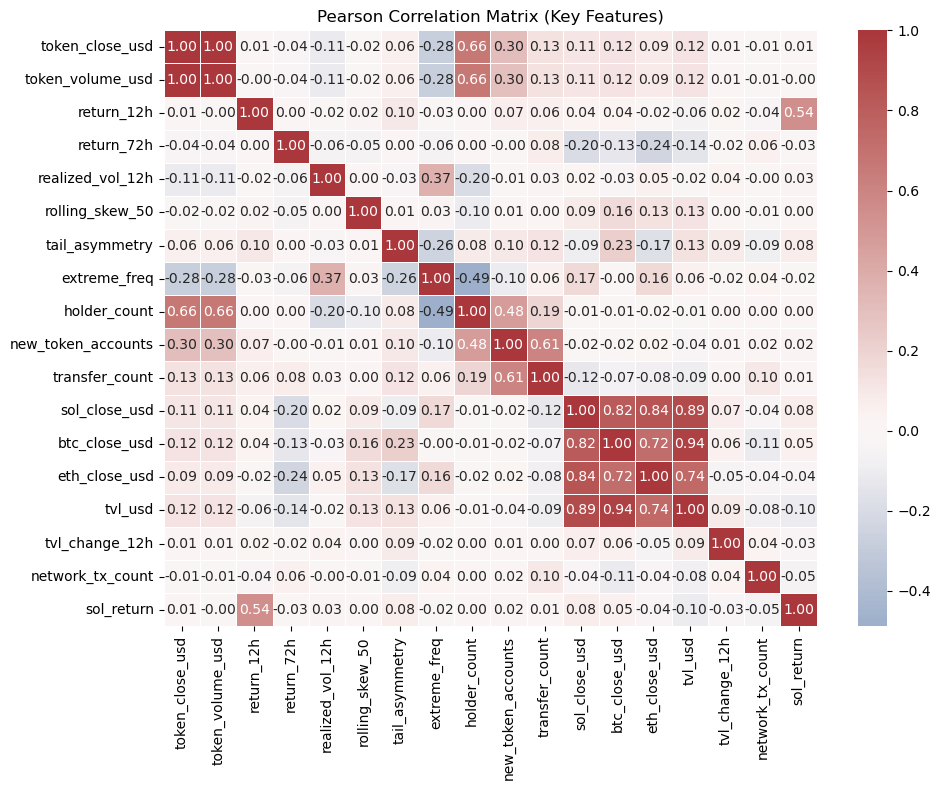

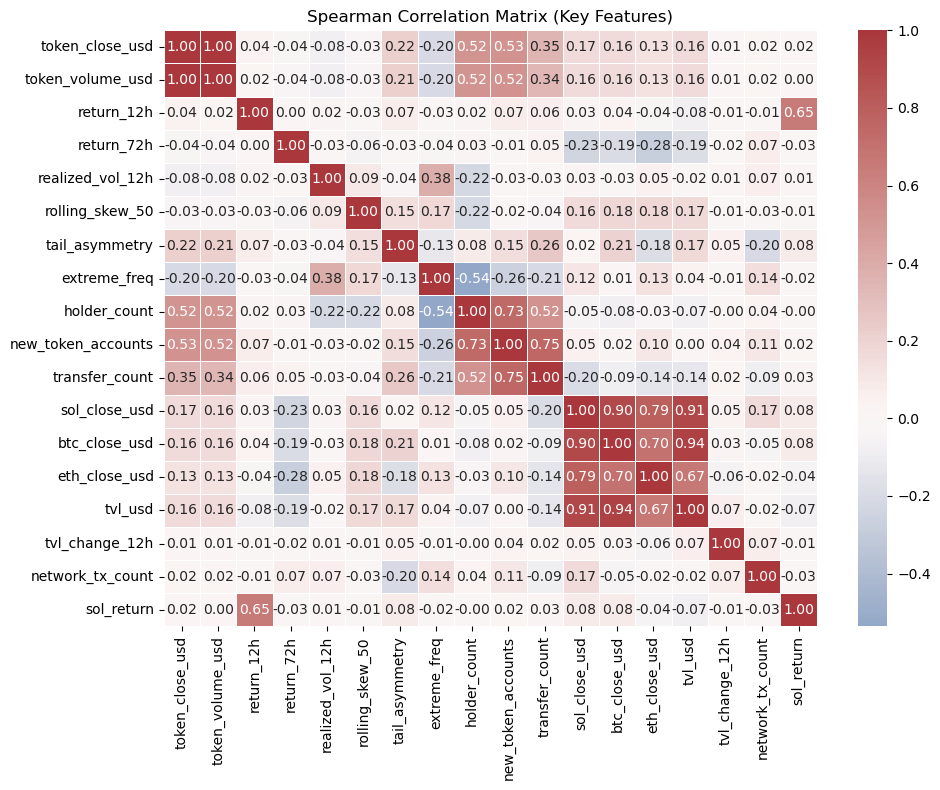

Highly correlated feature pairs (|r| > 0.85):
 token_close_usd  token_volume_usd    0.999379
btc_close_usd    tvl_usd             0.942418
sol_close_usd    tvl_usd             0.891793
dtype: float64


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Reload the dataset
df = pd.read_parquet("C:/Users/james/OneDrive/Documents/GitHub/solana-qrf-interval-forecasting/data/05data.parquet")

# 2. Rename only the core features for clarity
rename_map = {
    'close_usd': 'token_close_usd',
    'volume_usd': 'token_volume_usd',
    'logret_12h': 'return_12h',
    'logret_72h': 'return_72h',
    'realized_vol_12h': 'realized_vol_12h',
    'rolling_skew_50': 'rolling_skew_50',
    'tail_asymmetry': 'tail_asymmetry',
    'extreme_freq': 'extreme_freq',
    'holder_count': 'holder_count',
    'new_token_accounts': 'new_token_accounts',
    'transfer_count': 'transfer_count',
    'btc_eth_price_btc_close': 'btc_close_usd',
    'btc_eth_price_eth_close': 'eth_close_usd',
    'sol_price_close': 'sol_close_usd',
    'sol_price_volume': 'sol_volume_usd',
    'network_tx_tx_count': 'network_tx_count',
    'tvl_tvl_usd': 'tvl_usd',
    'tvl_tvl_change_12h': 'tvl_change_12h',
    'sol_return': 'sol_return'
}
df = df.rename(columns=rename_map)

# 3. Select only these numeric features
features = [
    'token_close_usd', 'token_volume_usd',
    'return_12h', 'return_72h',
    'realized_vol_12h', 'rolling_skew_50',
    'tail_asymmetry', 'extreme_freq',
    'holder_count', 'new_token_accounts', 'transfer_count',
    'sol_close_usd', 'btc_close_usd', 'eth_close_usd',
    'tvl_usd', 'tvl_change_12h', 'network_tx_count',
    'sol_return'
]

# 4. Subset and drop any rows with missing data in these features
sub = df[features].dropna()

# 5. Compute Pearson & Spearman correlation matrices
pearson = sub.corr(method='pearson')
spearman = sub.corr(method='spearman')

# 6. Plot Pearson correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=0.5)
plt.title("Pearson Correlation Matrix (Key Features)")
plt.tight_layout()
plt.show()

# 7. Plot Spearman correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman, annot=True, fmt=".2f", cmap="vlag", center=0, linewidths=0.5)
plt.title("Spearman Correlation Matrix (Key Features)")
plt.tight_layout()
plt.show()

# 8. Identify highly correlated feature pairs (|r| > 0.85)
mask = np.triu(np.ones_like(pearson, dtype=bool), k=1)
high_corr = (
    pearson.where(mask)
           .stack()
           .loc[lambda s: s.abs() > 0.85]
           .sort_values(ascending=False)
)
print("Highly correlated feature pairs (|r| > 0.85):\n", high_corr)

In [7]:
df.to_parquet("06data.parquet", index=False)

## Research Notes: Correlation & Redundancy Analysis

**What we did:**  
- Computed **Pearson** and **Spearman** correlations across 18 core features: prices, returns, volatility, tail metrics, on-chain counts, TVL, and cross-asset closes.  
- Visualized both correlation matrices via annotated heatmaps.  
- Extracted **highly correlated pairs** (|r| > 0.85):  
  - `token_close_usd` ↔ `token_volume_usd`  
  - `btc_close_usd` ↔ `tvl_usd`  
  - `tvl_usd`   ↔ `sol_close_usd`

**Key Takeaways:**  
- Several features move almost in lock-step at the 12h timescale—yet we’ll **keep all raw fields for now** so we can engineer richer intrabar indicators (ranges, OHLC returns, etc.).  
- After feature construction, we can prune true redundancies to streamline the final model input.

**Next Steps in Phase 1.3:**  
- Optionally compute **nonlinear dependencies** (mutual information) or **Variance Inflation Factors** to uncover subtler multicollinearity.  
- Finalize any additional diagnostics (e.g. hierarchical clustering of features) to inform Phase 2.

Once we’ve settled on these diagnostics, we’ll move into **Phase 2: Feature Engineering**, using our full set of raw and engineered features to feed the Quantile Regression Forest.  
